**Import Packages**

In [1]:
import cv2
import time
from PIL import Image
import os

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split, learning_curve
from sklearn import svm, metrics
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import recall_score, roc_auc_score, precision_score, roc_curve, auc

from skimage import img_as_ubyte, io, color
from skimage.feature import hog
from skimage import data, exposure

from imblearn.combine import SMOTEENN 
import numpy as np
from collections import Counter
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import random
import pickle
from scipy.stats import zscore

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import torch.optim as optim
from torch.optim import lr_scheduler

from google.colab.patches import cv2_imshow

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
%matplotlib inline

cuda:1


In [2]:
!pip install opencv-python==4.4.0.46

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_Folder_PG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset.zip', 'CW_Dataset', 'Test_Emotion_Recognition_Video_CNN.ipynb', 'Code', 'Video', 'Models', 'vgg16_model.pkl', 'cnn_model.pkl', 'Best_SIFT_SVM.pkl', 'Best_HOG_SVM.pkl', 'Best_HOG_MLP.pkl', 'elon144short.mp4', 'Test_Emotion_Recognition_Video_SVM_MLP.ipynb']


Copy and Unzip the dataset directly on the Colab server, which will make accessing the data much faster.

In [5]:
#Using Lab 07 code and changing the zipped folder name 
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset.zip

replace test/test_0288_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0828_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1505_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0317_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1055_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0647_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2986_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1923_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_0591_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2326_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_1383_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2676_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_3064_aligned.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace test/test_2819_aligned.jpg? [y

In [6]:
'''
#Code adapted from Lab 07
def import_selected_data(path):
    """Load images and labels from selected directories"""
    img_filenames = [imgfile for imgfile in sorted(os.listdir(path)) if imgfile.endswith('.jpg')]
    images = [io.imread(os.path.join(path, imgfile)) for imgfile in img_filenames]
    read_labels_file = open("labels/list_label_" + path + ".txt", "r")
    labels = [row.split(' ')[1][0] for row in read_labels_file]
    return images, labels

'''

'\n#Code adapted from Lab 07\ndef import_selected_data(path):\n    """Load images and labels from selected directories"""\n    img_filenames = [imgfile for imgfile in sorted(os.listdir(path)) if imgfile.endswith(\'.jpg\')]\n    images = [io.imread(os.path.join(path, imgfile)) for imgfile in img_filenames]\n    read_labels_file = open("labels/list_label_" + path + ".txt", "r")\n    labels = [row.split(\' \')[1][0] for row in read_labels_file]\n    return images, labels\n\n'

In [7]:
#X_test, y_test = import_selected_data("test")

In [8]:
# Defining our function which takes a model and test dataframe

def EmotionRecognition(model , test_path):

########################## SVM-HOG AND MLP-HOG ##########################

  img_filenames = [imgfile for imgfile in sorted(os.listdir(test_path)) if imgfile.endswith('.jpg')]
  images = [io.imread(os.path.join(test_path, imgfile)) for imgfile in img_filenames]
  read_labels_file = open("labels/list_label_" + test_path + ".txt", "r")
  labels = [row.split(' ')[1][0] for row in read_labels_file]
  X_test = images
  y_test = labels
  if model == SVM_HOG or model == MLP_HOG:
    #Adapted from Lab 06 and Lab 07
    # Convert descriptors into histograms of codewords for each image
    hist_list = []
    for i in range(len(X_test)):
      img = img_as_ubyte(color.rgb2gray(X_test[i]))
      HOG_des, HOG_image = hog( img, orientations=8, pixels_per_cell=(16, 16),  cells_per_block=(1, 1), visualize=True)
      hist_list.append(HOG_des)
    hist_array = np.vstack(hist_list)
    hist_list=np.array(hist_array)
    y_pred = model.predict(hist_list)

    plt.figure(figsize=(14, 11), linewidth=1)
    for i in range(1,6):
      j = random.randint(1,100)
      plt.subplot(1,5,i)
      plt.imshow(X_test[j])
      plt.title(f'Actual_Label: {y_test[j]} \n Predicted_Label: {y_pred[j]}')
      plt.tight_layout()
      plt.show

########################## SVM-SIFT AND MLP-SIFT ##########################

  elif model == SVM_SIFT:
    sift = cv2.SIFT_create()
    #Code taken from Lab 07
    hist_list = []
    des_list = []
    for i in range(len(X_test)):
        img = img_as_ubyte(color.rgb2gray(X_test[i]))
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
          des_list.append(des)
    des_array = np.vstack(des_list)  
    k = 70
    # Use MiniBatchKMeans for faster computation and lower memory usage
    batch_size = 178194 
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size).fit(des_array)
    for x in des_list:
      hist = np.zeros(k)
      idx = kmeans.predict(x)
      for j in idx:
        hist[j] = hist[j] + (1 / len(x))
      # hist = scale.transform(hist.reshape(1, -1))
      hist_list.append(hist)
    hist_array=np.vstack(hist_list)
    y_pred = model.predict(hist_array).tolist()
    
    #Code taken from Lab 07
    fig, axes = plt.subplots(2, 5, figsize=(14, 7), sharex=True, sharey=True)
    ax = axes.ravel()

    for i in range(10):
        ax[i].imshow(X_test[i])
        ax[i].set_title(f'Label: {y_test[i]} \n Prediction: {y_pred[i]}')
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()


      
    
  else:
    print("Model not found, check your spelling")

In [9]:
########################### Loading our MLP Models ##########################

# MLP with HOG
with open("/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder_PG/Best_HOG_MLP.pkl", "rb") as mlp_hog:
    MLP_HOG = pickle.load(mlp_hog)

########################### Loading our SVM Models ##########################

#SVM with SIFT
with open("/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder_PG/Best_SIFT_SVM.pkl", "rb") as svm_sift:
    SVM_SIFT = pickle.load(svm_sift)


#SVM with HOG
with open("/content/drive/My Drive/Colab Notebooks/Computer Vision/CW_Folder_PG/Best_HOG_SVM.pkl", "rb") as svm_hog:
    SVM_HOG = pickle.load(svm_hog)


  

test_path = "test"


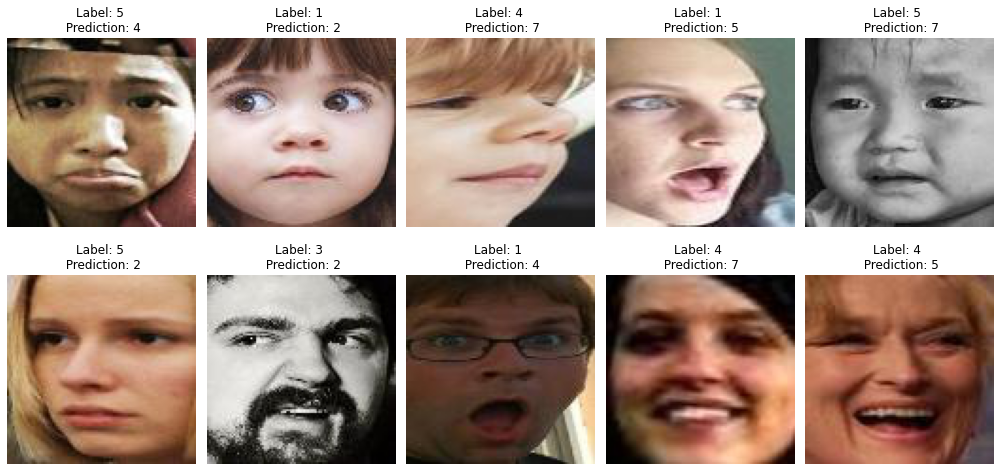

In [16]:
# Testing our EmotionalRecognition function - input a model variable from above to test

EmotionRecognition(SVM_SIFT ,test_path)